# Разработка поиска изображений по запросу пользователя

## Описание проекта

In [ ]:
# !pip install --upgrade -r requirements.txt
# !pip install transformers

In [ ]:
import os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models

from PIL import Image

from transformers import BertModel, BertTokenizer, logging

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBRegressor

from scipy.spatial.distance import cosine

In [ ]:
# !pipreqsnb . --force

In [ ]:
plt.style.use('ggplot')
logging.set_verbosity_error()

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

torch.manual_seed(7)
np.random.seed(7)

In [ ]:
PATH = 'to_upload'

TRAIN_IMG_FOLDER = os.path.join(PATH, 'train_images')
TEST_IMG_FOLDER = os.path.join(PATH, 'test_images')

TRAIN_DATA_CSV = os.path.join(PATH, 'train_dataset.csv')

TEST_IMAGES_CSV = os.path.join(PATH, 'test_images.csv')
TEST_QUERIES_CSV = os.path.join(PATH, 'test_queries.csv')

CROWD_ANNOT_TSV = os.path.join(PATH, 'CrowdAnnotations.tsv')
EXPERT_ANNOT_TSV = os.path.join(PATH, 'ExpertAnnotations.tsv')

## Исследовательский анализ данных

In [ ]:
def load_df(_path, **kwargs):
    """загружаем данные, выводим базовую информацию, возвращаем датафрейм"""
    _df = pd.read_csv(_path, **kwargs)
    _df.info()
    display(_df.sample(3))
    print('Полные дубликаты ', _df.duplicated().sum())
    display(_df.describe(include=object))
    return _df

### Обучающий датасет

В файле `train_dataset.csv` собрана информация, необходимая для обучения:
- имя файла изображения `image` в папке `train_images`
- идентификатор описания `query_id` в формате `<имя файла изображения>#<порядковый номер описания>`
- текст описания `query_text`

Для одной картинки может быть доступно до 5 описаний.


In [ ]:
df_train = load_df(TRAIN_DATA_CSV)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image                     query_id   
5756  3514179514_cbc3371b92.jpg  3542484764_77d8920ec9.jpg#2  \
913   1262583859_653f1469a9.jpg  3741827382_71e93298d0.jpg#2   
3619  3584930205_a3f58a4b7c.jpg  3498997518_c2b16f0a0e.jpg#2   

                                             query_text  
5756       The cricketer is swinging a bat in the air .  
913   A young boy jumps around on a blue mat with a ...  
3619  A football player is tackling the player with ...

Полные дубликаты  0


image                     query_id   
count                        5822                         5822  \
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

- Пропусков нет
- Полных дубликатов нет
- Уникальных картинок 1000
- Чуть меньше уникальных запросов – 977 вариантов

Проверим сколько данных, где имя файла и запрос совпадают

In [ ]:
mask_train = df_train['image'] == df_train['query_id'].str.split('#').str[0]
mask_train.sum()

158

Всего 158 совпадающих пар файл-запрос

### Тестовые запросы

В файле `test_queries.csv` находится информация, необходимая для тестирования:
- идентификатор запроса в формате `<имя файла изображения>#<порядковый номер описания>`
- текст запроса
- релевантное изображение.

Для одной картинки может быть доступно до 5 описаний.


In [ ]:
test_query = load_df(TEST_QUERIES_CSV, delimiter='|', index_col=0)

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


query_id   
84   2308256827_3c0a7d514d.jpg#4  \
432   404850242_3a55a4c874.jpg#2   
45    191003283_992257f835.jpg#0   

                                            query_text   
84   The little boy is smiling as he crosses a rope...  \
432     An older dark haired woman is taking a picture   
45   A little blond boy and a young woman in jeans ...   

                         image  
84   2308256827_3c0a7d514d.jpg  
432   404850242_3a55a4c874.jpg  
45    191003283_992257f835.jpg

Полные дубликаты  0


query_id   
count                           500  \
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text   
count                                                 500  \
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

Проверим где имя файла совпадает с запросом

In [ ]:
mask_test = test_query['image'] == test_query['query_id'].str.split('#').str[0]
mask_test.sum()

500

То есть в тестовом датасете у нас все пары – соответствующие.

### Тестовые изображения

In [ ]:
test_img = load_df(TEST_IMAGES_CSV)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


image
24  3421547427_53411b6278.jpg
54  2714674623_8cd05ac114.jpg
32  3030079705_0dee8a3e89.jpg

Полные дубликаты  0


image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1

### Экспертные оценки

Заказчик предоставил данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где
- 1 — изображение и запрос совершенно не соответствуют друг другу,
- 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,
- 3 — запрос и текст соответствуют с точностью до некоторых деталей,
- 4 — запрос и текст соответствуют полностью.

Переведем интервал оценок от 1-4 в более удобный вид от 0 до 3

In [ ]:
annot_expert = load_df(EXPERT_ANNOT_TSV, delimiter='\t', header=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


0                            1  2  3  4
2711   300314926_0b2e4b64f5.jpg  1472230829_803818a383.jpg#2  1  1  2
3958  3388330419_85d72f7cda.jpg   370713359_7560808550.jpg#2  1  1  2
1734  2554081584_233bdf289a.jpg  2647049174_0fb47cee2e.jpg#2  1  1  1

Полные дубликаты  0


0                            1
count                        5822                         5822
unique                       1000                          977
top     3107513635_fe8a21f148.jpg  2600867924_cd502fc911.jpg#2
freq                           10                           34

Переименуем колонки для удобства:

In [ ]:
to_rename = {
    k:v for k,v
    in zip(range(5), ['image', 'query_id', 'expt_1', 'expt_2', 'expt_3'])
}
annot_expert = annot_expert.rename(columns=to_rename)
annot_expert[['expt_1', 'expt_2', 'expt_3']] = annot_expert[['expt_1', 'expt_2', 'expt_3']].sub(1)
annot_expert.head(2)

image                     query_id  expt_1  expt_2   
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       0       0  \
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       0       0   

   expt_3  
0       0  
1       1

Проверим, сколько уникальных комбинаций изображение+запрос

In [ ]:
(annot_expert['image'] + annot_expert['query_id']).nunique()

5822

То есть все пары изображение+запрос уникальны, количество совпадает с общим количеством строк и соответствует размеру трейна.

Посмотрим на распределение оценок там где совпадает файл и запрос

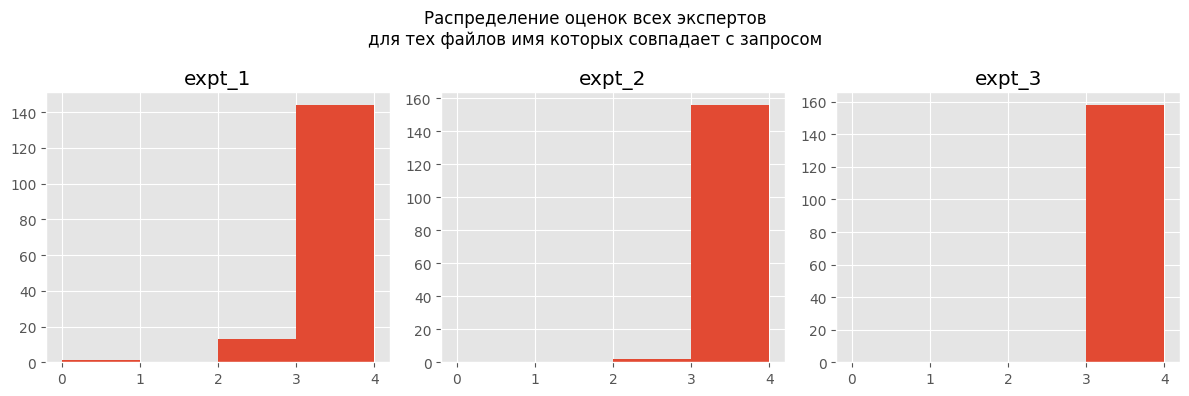

In [ ]:
mask_expt = annot_expert['image'] == annot_expert['query_id'].str.split('#').str[0]
(annot_expert[mask_expt][['expt_1','expt_2','expt_3']]
 .hist(bins=4,
       range=(0,4),
       layout=(1,3),
       figsize=(12,4),
      )
)
plt.suptitle('Распределение оценок всех экспертов\nдля тех файлов имя которых совпадает с запросом')
plt.tight_layout()
plt.show()

Проверим если совпадает имя файла и запрос, но не совпадает мнение экспертов

In [ ]:
annot_expert['max'] = annot_expert[['expt_1', 'expt_2', 'expt_3']].max(axis=1)
annot_expert['min'] = annot_expert[['expt_1', 'expt_2', 'expt_3']].min(axis=1)
annot_expert[mask_expt & (annot_expert['max']-annot_expert['min'])>0]

image                     query_id  expt_1  expt_2   
1296  2396691909_6b8c2f7c44.jpg  2396691909_6b8c2f7c44.jpg#2       2       3  \
1661  2526585002_10987a63f3.jpg  2526585002_10987a63f3.jpg#2       2       2   
1672  2533424347_cf2f84872b.jpg  2533424347_cf2f84872b.jpg#2       2       3   
1822  2599444370_9e40103027.jpg  2599444370_9e40103027.jpg#2       2       3   
2318  2856080862_95d793fa9d.jpg  2856080862_95d793fa9d.jpg#2       2       3   
2450  2894217628_f1a4153dca.jpg  2894217628_f1a4153dca.jpg#2       2       2   
2606  2943023421_e297f05e11.jpg  2943023421_e297f05e11.jpg#2       2       3   
3070  3119875880_22f9129a1c.jpg  3119875880_22f9129a1c.jpg#2       2       3   
3612  3259991972_fce3ab18b2.jpg  3259991972_fce3ab18b2.jpg#2       2       3   
3650  3270691950_88583c3524.jpg  3270691950_88583c3524.jpg#2       2       3   
3765  3320356356_1497e53f80.jpg  3320356356_1497e53f80.jpg#2       2       3   
3921  3375070563_3c290a7991.jpg  3375070563_3c290a7991.jpg#2       2       3   
4318  3498997518_c2b16f0a0e.jpg  3498997518_c2b16f0a0e.jpg#2       2       3   
5573   542317719_ed4dd95dc2.jpg   542317719_ed4dd95dc2.jpg#2       0       3   

      expt_3  max  min  
1296       3    3    2  
1661       3    3    2  
1672       3    3    2  
1822       3    3    2  
2318       3    3    2  
2450       3    3    2  
2606       3    3    2  
3070       3    3    2  
3612       3    3    2  
3650       3    3    2  
3765       3    3    2  
3921       3    3    2  
4318       3    3    2  
5573       3    3    0

Разногласие экспертов в оценке последней записи 0-3-3 больше всего похоже на ошибку, но это не точно. В остальном оценки согласуются. Оставлю как есть, исправлять или удалять не буду, все равно усреднится в нужную сторону.

Посмотрим, что на краудсорсе.

### Краудсорсинговые оценки

В файле содержатся данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.


In [ ]:
annot_crowd = load_df(CROWD_ANNOT_TSV, delimiter='\t', header=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


0                            1    2  3  4
27528  3216926094_bc975e84b9.jpg  2869491449_1041485a6b.jpg#2  0.0  0  3
42618   424416723_19c56cb365.jpg  3518126579_e70e0cbb2b.jpg#2  0.0  0  3
40570  3686924335_3c51e8834a.jpg  2573625591_70291c894a.jpg#2  0.0  0  3

Полные дубликаты  0


0                           1
count                       47830                       47830
unique                       1000                        1000
top     1572532018_64c030c974.jpg  249394748_2e4acfbbb5.jpg#2
freq                          120                         169

Переименуем колонки в удобочитаемый вид и посмотрим как получилось.

In [ ]:
to_rename = {
    k:v for k,v
    in zip(range(5), ['image', 'query_id', 'confirmed_frac', 'confirmed_count', 'non_confirmed_count'])
}
annot_crowd = annot_crowd.rename(columns=to_rename)
annot_crowd.head(2)


image                     query_id  confirmed_frac   
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2             1.0  \
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2             0.0   

   confirmed_count  non_confirmed_count  
0                3                    0  
1                0                    3

Уникальных изображений 1000, но количество записей ~48тыс.

Проверим, сколько уникальных комбинаций изображение+запрос

In [ ]:
(annot_crowd['image'] + annot_crowd['query_id']).nunique()

47830

То есть комбинации изображения и запроса уникальны.

Посмотрим на распределение оценок

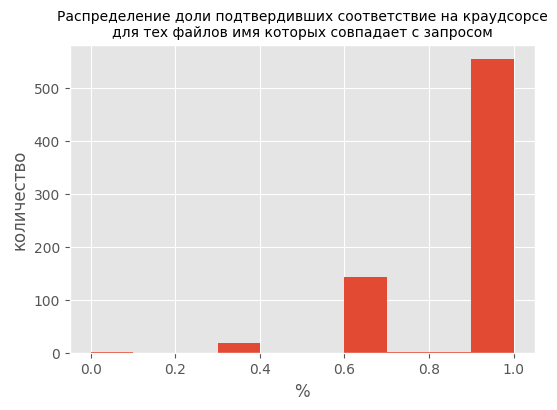

In [ ]:
mask_crowd = annot_crowd['image'] == annot_crowd['query_id'].str.split('#').str[0]
annot_crowd[mask_crowd]['confirmed_frac'].hist(figsize=(6,4))
plt.title('Распределение доли подтвердивших соответствие на краудсорсе\nдля тех файлов имя которых совпадает с запросом', fontsize=10)
plt.ylabel('количество')
plt.xlabel('%')
plt.show()

Совместим оценки экспертов и крауда полностью, все данные какие есть

In [ ]:
annot_all = annot_crowd.merge(annot_expert, on=['image', 'query_id'], how='outer')
annot_all.shape

(51323, 10)

In [ ]:
annot_all['expt'] = annot_all[['expt_1', 'expt_2', 'expt_3']].mean(axis=1).divide(3)

In [ ]:
annot_all.loc[annot_all['confirmed_frac'].isna(), 'target'] = annot_all['expt']
annot_all.loc[annot_all['expt'].isna(), 'target'] = annot_all['confirmed_frac']
annot_all.loc[annot_all['target'].isna(), 'target'] = annot_all['expt']*0.6 + annot_all['confirmed_frac']*0.4

- Объединим все оценки и обучающий датасет
- Заполним недостающие описания
- Некоторые запросы из краудсорса не имеют подходящих изображений, удалим пропуски

В итоге получили обучающую выборку около 50 тыс записей

In [ ]:
df_train = df_train.merge(annot_all[['image', 'query_id', 'target']], on=['image', 'query_id'], how='outer')
df_train['query_text'] = df_train.sort_values(by=['query_id', 'query_text']).groupby('query_id')['query_text'].ffill()

In [ ]:
df_train = df_train.dropna().reset_index(drop=False)
print('Размер датасета после объединения', df_train.shape)

Размер датасета после объединения (50214, 5)


### Выводы

**Обучающий датасет**
- Пропусков нет
- Полных дубликатов нет
- Уникальных картинок 1000
- Чуть меньше уникальных запросов – 977 вариантов
- 158 изображений, для которых указан правильный запрос, и остальное произвольные пересечения запросов и картинок

**Тестовые запросы**
- 500 пар записей с указанием запроса и правильного изображения
- дубликатов нет

**Тестовые изображения**
- дубликатов нет

**Оценки экспертов и краудсорса**
- оценку экспертов перевели в шкалу от 0 до 3 и усрединили
- проверили оценки краудсорса – там где изображение и запрос совпадают, в основном есть подтверждающая оценка от краудсорса, то есть это адекватные данные по оценке, которые можно использовать
- смешали краудсорс с оценками экспертов в пропорции 2:3 в пользу экспертной оценки
- обогатили обучающий датасет за счет дополнительных данных из краудсорса
- итоговое количество записей в обучающем датасете ~50 тыс

## Проверка данных


### Проверка изображений и запросов

In [ ]:
def make_square(im, min_size=256, fill_color=(255, 255, 255, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [ ]:
def split_long_text(txt, num_words):
    txt = txt.split()
    return '\n'.join(' '.join(txt[i:i+num_words]) for i in range(0, len(txt), num_words)).replace('.','')

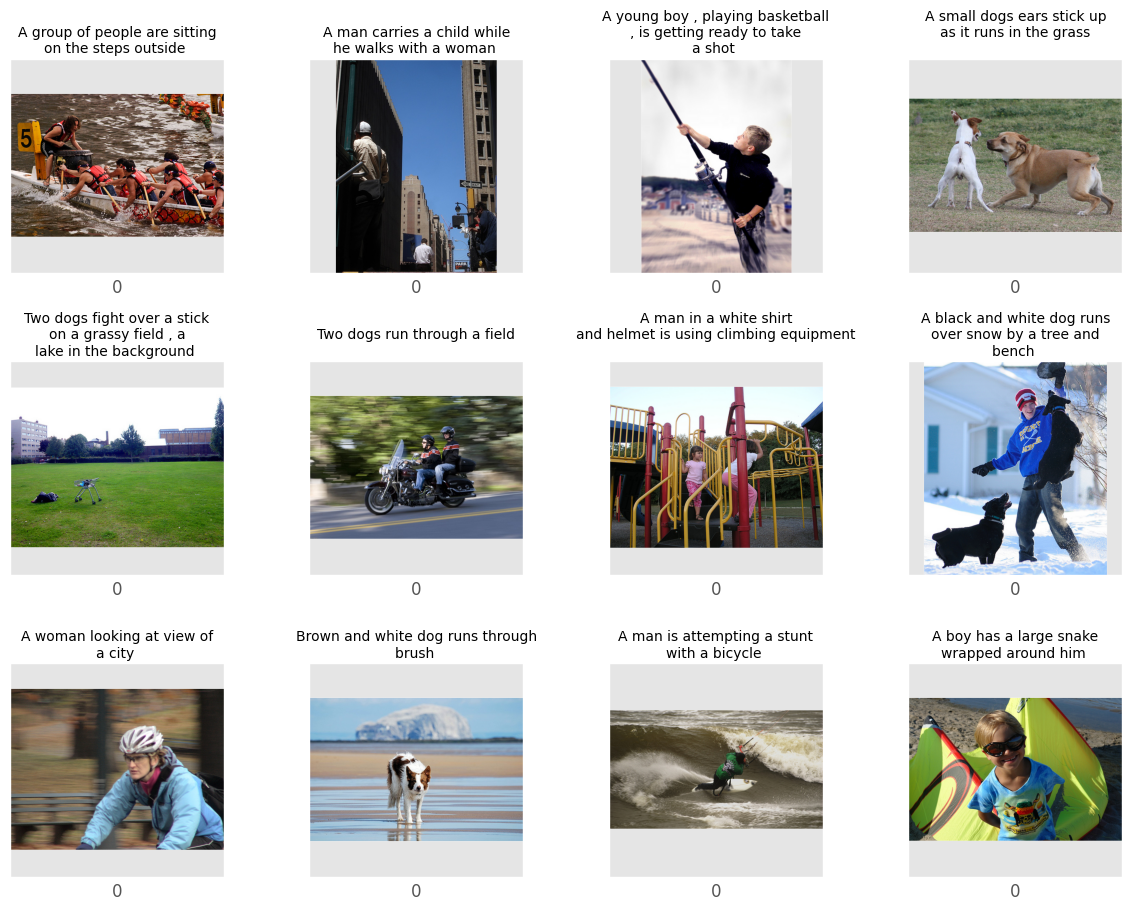

In [ ]:
df_sample = df_train.sample(12)[['image', 'query_text', 'target']]
fig = plt.figure(figsize=(12,12))
for i in range(df_sample.shape[0]):
    fig.add_subplot(4, 4, i+1)
    query_text = df_sample.iloc[i]['query_text']
    file_path = os.path.join(TRAIN_IMG_FOLDER, df_sample.iloc[i]['image'])
    img = Image.open(file_path)
    plt.title(split_long_text(query_text, 6), fontsize=10, wrap=True)
    plt.imshow(make_square(img))
    plt.xlabel(df_sample.iloc[i]['target'].astype(int))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(w_pad=2)
plt.show()

### Законодательные ограничения

В датасете есть данные, которые попадают под ограничения по обработке изображений: поисковым сервисам и сервисам запрещено без разрешения родителей или законных представителей предоставлять любую информацию про детей.

In [ ]:
to_remove_kids = [
    'babies',
    'baby',
    'boy',
    'child',
    'girl',
    'kid',
    'toddler',
    'teenage'
]

По условию задания нам необходимо удалить из обучения изображения с детьми. Соответственно аналогичным образом необходимо отфильтровать и тестовый датасет, иначе модель, которая при обучении не видела детей, начинает выдавать их по запросам собак. Таким образом даже если мы забаним запросы по детям, все равно нарушали бы закон, выдавая эти фото под видом других запросов, если бы они остались в тесте.

- удаляем детские изображения из обучающих данных
- составляем список запрещенных изображений в тестах
    - фильтруем тестовые запросы
    - фильтруем каталог фотографий

In [ ]:
mask_kids_train = df_train.query_text.str.lower().str.contains('|'.join(to_remove_kids))
prohibited_images_train = df_train.loc[mask_kids_train]['query_id'].drop_duplicates().str.split('#').str[0]
df_train_filtered = df_train.loc[~df_train['image'].isin(prohibited_images_train)].reset_index(drop=True)

mask_kids_test = test_query.query_text.str.lower().str.contains('|'.join(to_remove_kids))
prohibited_images_test = test_query.loc[mask_kids_test]['query_id'].drop_duplicates().str.split('#').str[0]
test_query_filtered = test_query.loc[~test_query['image'].isin(prohibited_images_test)].reset_index(drop=True)
test_img_filtered = test_img.loc[~test_img['image'].isin(prohibited_images_test)].reset_index(drop=True)

In [ ]:
print('Размер датасетов df_train, test_query, test_img до фильтрации детей')
[print(f'{d.shape}') for d in [df_train, test_query, test_img]]
print('\nИ после фильтрации')
[print(f'{d.shape}') for d in [df_train_filtered, test_query_filtered, test_img_filtered]];

Размер датасетов df_train, test_query, test_img до фильтрации детей
(50214, 5)
(500, 3)
(100, 1)

И после фильтрации
(35672, 5)
(280, 3)
(56, 1)


### Распределение целевого признака

Сформируем итоговый датасет для работы и проверим распределение таргета в итоговом датасете

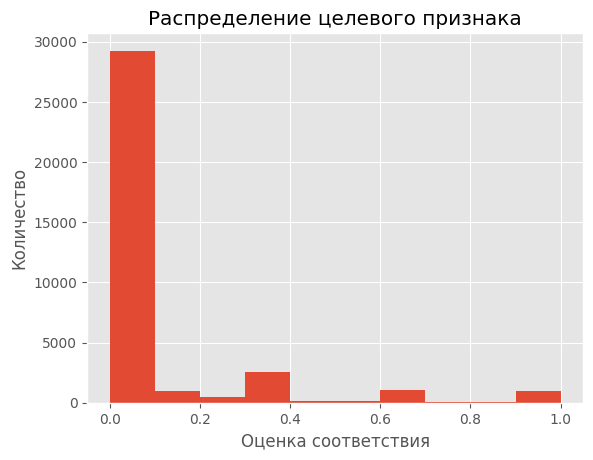

In [ ]:
df_train_filtered = df_train_filtered[['image', 'query_text', 'target']].reset_index(drop=True)

df_train_filtered['target'].hist()
plt.title('Распределение целевого признака')
plt.ylabel('Количество')
plt.xlabel('Оценка соответствия')
plt.show()

Видно, что положительных соответствий очень мало, зато много несоответствующих запросов.

## Эмбеддинги

### Векторизация изображений

- подготовим модель ResNet18
- загрузим веса ImageNet и оттуда возьмем трансформации
- преобразуем все изображения в цветные RGB
- построим эмбеддинги изображений


In [ ]:
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
resnet = models.resnet18(weights=weights)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Удалим последний полносвязный (fc – fully connected) слой `Linear`

In [ ]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
for param in resnet.parameters():
    param.requires_grad_(False)
resnet.to(device)
resnet.eval();

In [ ]:
def get_image_embeddings(data_folder, image_list):
    image_embeddings = []
    for image in image_list:
        img = Image.open(os.path.join(data_folder, image)).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0).to(device)
        embeddings = resnet(input_tensor).squeeze(0).flatten().to('cpu').numpy()
        image_embeddings.append(embeddings)

    image_embeddings = np.array(image_embeddings)
    return image_embeddings

In [ ]:
%%time
image_embeddings = get_image_embeddings(TRAIN_IMG_FOLDER, df_train_filtered.image.to_list())
image_embeddings.shape

CPU times: user 7min 49s, sys: 2.36 s, total: 7min 51s
Wall time: 4min 45s


(35672, 512)

### Векторизация текстов

Проведем векторизацию текстов запросов с помощью BERT
- загрузим предобученный трансформер и токенизатор
- токенизируем текстовые запросы
- в цикле по батчам построим эмбеддинги

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

def get_text_embeddings(text_list):
    tokens_bert = bert_tokenizer(text_list,
                                 padding=True,
                                 truncation=True,
                                 add_special_tokens=True,
                                 return_attention_mask=True,
                                 return_token_type_ids=False,
                                 return_tensors='pt').to(device)
    range_start = 0
    range_end = len(tokens_bert.input_ids)
    batch_size = 100
    text_embeddings = list()
    for i in range(range_start, range_end, batch_size):
        batch_start = i
        batch_end = i + batch_size
        batch_token = tokens_bert.input_ids[batch_start:batch_end]
        batch_mask = tokens_bert.attention_mask[batch_start:batch_end]
        with torch.no_grad():
            batch_embeddings = bert_model(batch_token, attention_mask=batch_mask)
        text_embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu())

    text_embeddings = np.concatenate(text_embeddings)
    return text_embeddings

In [ ]:
%%time
text_embeddings = get_text_embeddings(df_train_filtered.query_text.to_list())
text_embeddings.shape

CPU times: user 1min 13s, sys: 88.1 ms, total: 1min 13s
Wall time: 1min 13s


(35672, 768)

### Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

- Размер эмбеддингов изображений 2048
- Размер текстовых эмбеддингов 768
- Общий размер 1280 признаков

In [ ]:
concat_embeddings = lambda x,y: np.concatenate((x, y), axis=1)

In [ ]:
emb_train = concat_embeddings(image_embeddings, text_embeddings)
emb_train.shape

(35672, 1280)

## Обучение модели предсказания соответствия

Для решения задачи классификации – соответствует изображение запросу или нет протестируем несколько моделей:
- константную модель DummyRegressor для общего понимания адекватности моделей
- LinearRegression
- XGBRegressor
- полносвязная нейронная сеть

Для выбора лучшей модели будем использовать метрику RMSE

### Подготовка обучающего и валидационного датасета

Разделим датасет на тренировочную и тестовую выборки
- чтобы исключить попадание дублирующихся изображения и в обучающую, и в тестовую выборки воспользуемся методом `GroupShuffleSplit`
- в качестве контрольного столбца для разбиения групп укажем имя файла `image`

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_idx, valid_idx = next(gss.split(X=emb_train, groups=df_train_filtered['image']))

X_train, X_valid = emb_train[train_idx], emb_train[valid_idx]
y_train, y_valid = df_train_filtered.loc[train_idx, 'target'], df_train_filtered.loc[valid_idx, 'target']


In [ ]:
print(f'Обучающая выборка {X_train.shape}\n'
      f'Валидационная выборка {X_valid.shape}'
     )

Обучающая выборка (24840, 1280)
Валидационная выборка (10832, 1280)


### Подготовка полносвязной нейронной сети

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self, *args, num_epochs=150, batch_size=50, dropout_n=0, learning_rate=0.0001):

        super(NeuralNet, self).__init__()

        self._estimator_type = 'regressor'
        self.input_n, self.hidden, self.output_n = args

        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.dropout_n = dropout_n
        self.learning_rate = learning_rate

        self.layer_list = nn.Sequential(
            nn.Linear(self.input_n, self.hidden),
            nn.Tanh(),
            nn.Dropout(p=self.dropout_n),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_n),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_n),
            nn.Linear(self.hidden, self.output_n),   # линейный выход
        )

    def forward(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.dp = nn.Dropout(p=self.dropout_n)
        return self

    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

    def fit(self, x, y):
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y.values)
        self.apply(self.init_weights)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        loss = nn.MSELoss()
        num_batches = int(np.ceil(x.shape[0]/self.batch_size))
        for epoch in range(self.num_epochs):
            order = np.random.permutation(len(x))
            for batch_idx in range(num_batches):
                start_index = batch_idx * self.batch_size
                optimizer.zero_grad()
                batch_indexes = order[start_index:start_index+self.batch_size]
                X_batch = x[batch_indexes]
                y_batch = y[batch_indexes]
                preds = self.forward(X_batch).flatten()
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()

    def predict(self, x):
        x = torch.FloatTensor(x)
        self.eval()
        return self.forward(x).detach().numpy()[:,0]

### Обучение и валидация моделей

In [ ]:
%%time
model_list = [
    DummyRegressor(),
    LinearRegression(n_jobs=-1),
    XGBRegressor(n_estimators=150, max_depth=3, n_jobs=-1, random_state=7),
    NeuralNet(512+768, 256, 1, num_epochs=200, batch_size=50, dropout_n=0.1, learning_rate=0.0001)
    ]

model_result = pd.DataFrame(columns=['model_name', 'model', 'rmse'])
for model in model_list:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_valid)
    model_name = type(pipe[-1]).__name__
    model_result.loc[len(model_result)] = {
        'model_name': model_name,
        'model': pipe,
        'rmse': mean_squared_error(y_valid, y_pred, squared=False)
        }

model_result.sort_values(by='rmse')

CPU times: user 13min 31s, sys: 5.83 s, total: 13min 37s
Wall time: 6min 48s


model_name                                              model   
3         NeuralNet  (StandardScaler(), NeuralNet(\n  (layer_list):...  \
2      XGBRegressor  (StandardScaler(), XGBRegressor(base_score=Non...   
0    DummyRegressor               (StandardScaler(), DummyRegressor())   
1  LinearRegression    (StandardScaler(), LinearRegression(n_jobs=-1))   

         rmse  
3    0.199819  
2    0.202488  
0    0.211004  
1  808.001039

In [ ]:
best_model = model_result.iloc[model_result['rmse'].argmin()]['model']
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 NeuralNet(
  (layer_list): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
))])

Результаты получились примерно одного уровня у всех моделей, даже у лучших моделей качество предсказания чуть выше чем у константной модели 🫣

## Проверка

### Тестирование модели

Проведем сравнение предсказания лучшей модели и поиска по косинусному расстоянию
- Создадим ембеддинги для тестовых фильтрованных изображений
- Отберем 10 случайных запросов и для контроля добавим два гарантированно детских
- Подготовим функцию для предсказания любого запроса по тестовым эмбеддингам
- Предскажем лучшей моделью наиболее подходящие изображения с максимальной оценкой соответствия
- Рассчитаем косинусное расстояние от оригинального изображения до ближайшего из тестового датасета (0 у оригинала, выбираем второе по счету)
- Выведем для сравнения оба найденных изображения и оригинал, соответствующий запросу

In [ ]:
test_img_embeddings_filtered = get_image_embeddings(TEST_IMG_FOLDER, test_img_filtered.image)
test_sample = test_query_filtered.sample(10)
test_sample = pd.concat([test_sample,
                         test_query[test_query.query_text.str.lower().str.contains('|'.join(to_remove_kids))].sample(2)]
                       ).sample(frac=1).reset_index(drop=True)

In [ ]:
def get_image(query, image_emded, data_image):

    data_len = len(image_emded)

    query_text = query.query_text
    text_embed = get_text_embeddings(query_text)[0]
    true_image = query.query_id.split('#')[0]
    true_embed = get_image_embeddings(TEST_IMG_FOLDER, [true_image])[0]

    preds = []
    dist = []
    for i in range(data_len):
        X = concat_embeddings(
            image_emded[i].reshape(1,-1),
            text_embed.reshape(1,-1)
        )
        preds.append(best_model.predict(X)[0])
        dist.append(cosine(true_embed, image_emded[i]))

    max_idx = np.argmax(preds)
    cos_idx = np.array(dist).argsort()[1]

    return {'txt': query_text,
            'src': true_image,
            'img_by_pred': data_image.iloc[max_idx].image,
            'img_by_dist': data_image.iloc[cos_idx].image,
            'cos': dist[cos_idx],
            'scr': preds[max_idx],
            'cos_idx': cos_idx,
            'max_idx': max_idx
           }

In [ ]:
result = pd.DataFrame(columns=['txt', 'src', 'img_by_pred', 'img_by_dist', 'cos', 'scr', 'cos_idx', 'max_idx'])
for sample in test_sample.itertuples():
    preds = get_image(sample, test_img_embeddings_filtered, test_img_filtered)
    result.loc[len(result)] = preds

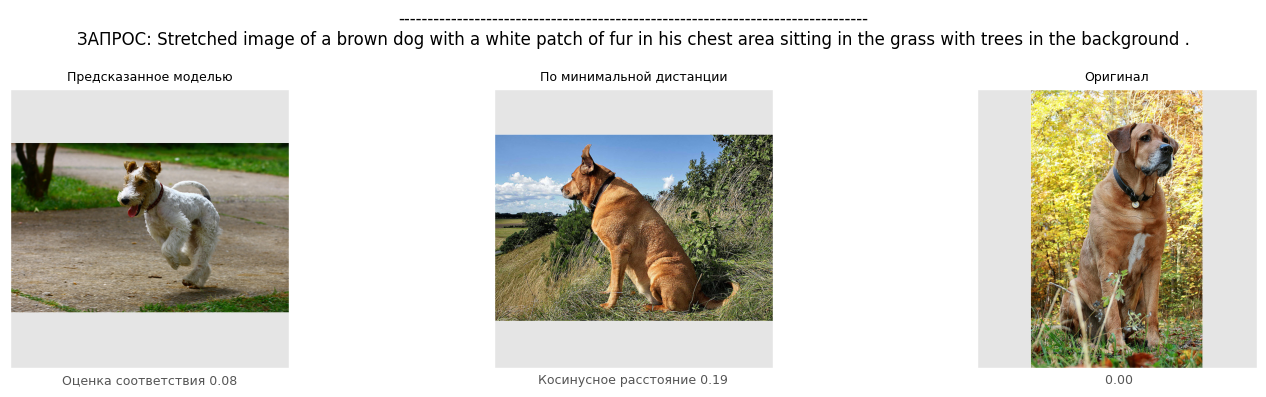

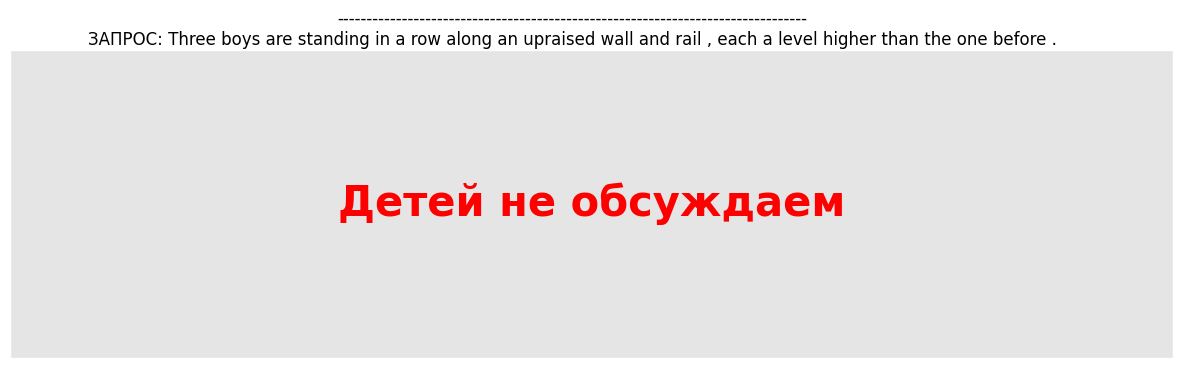

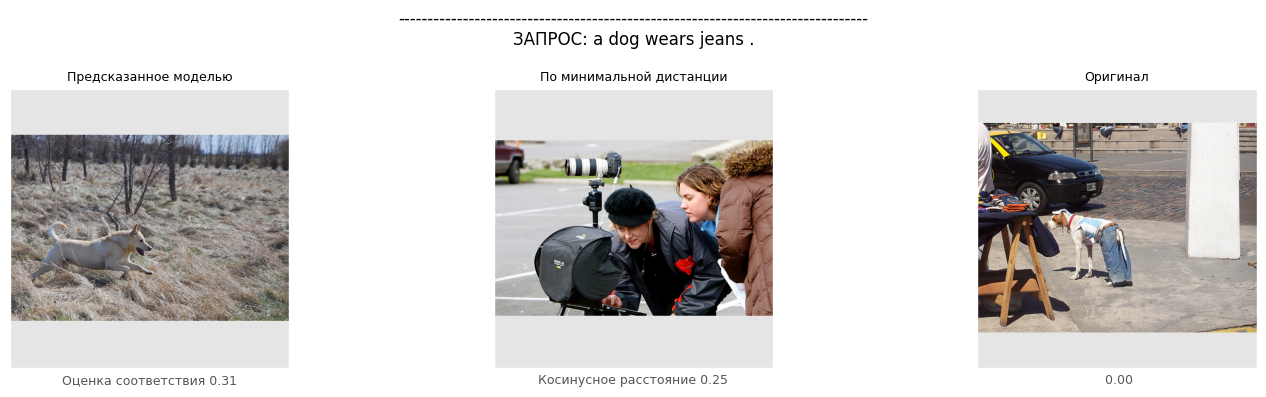

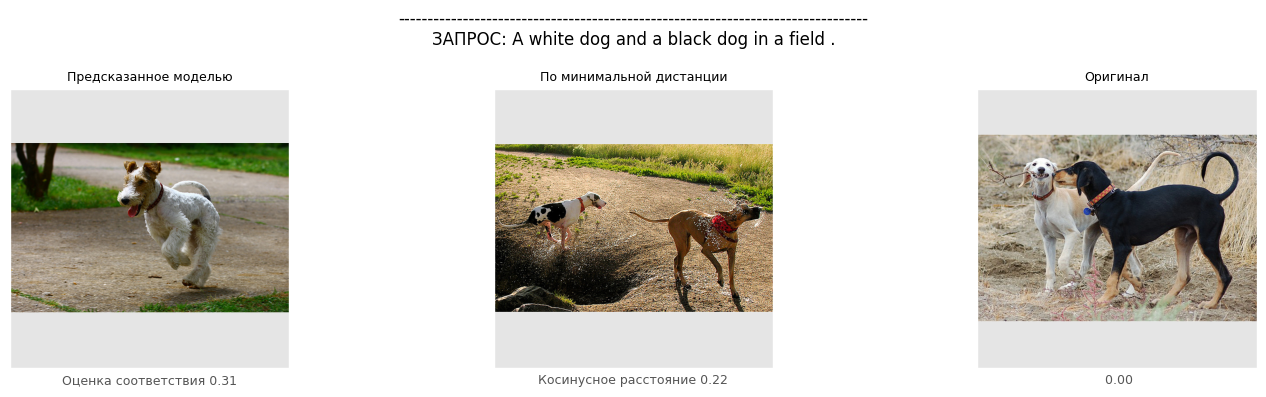

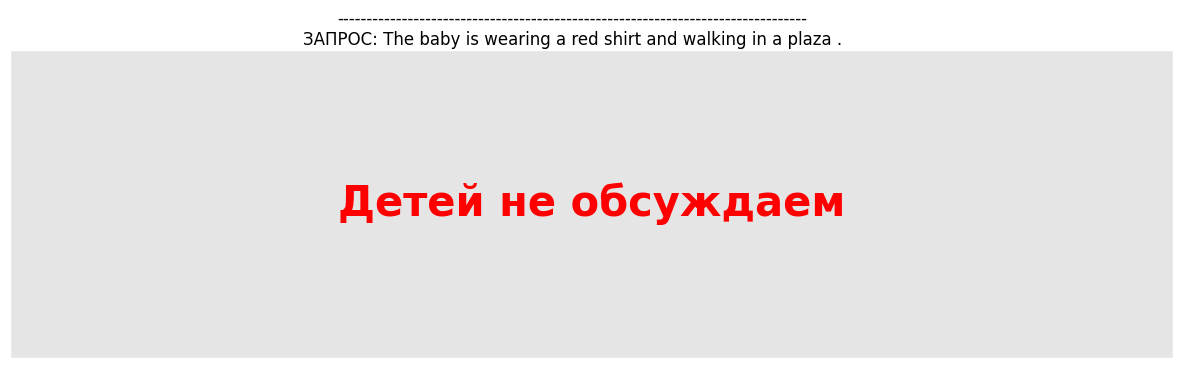

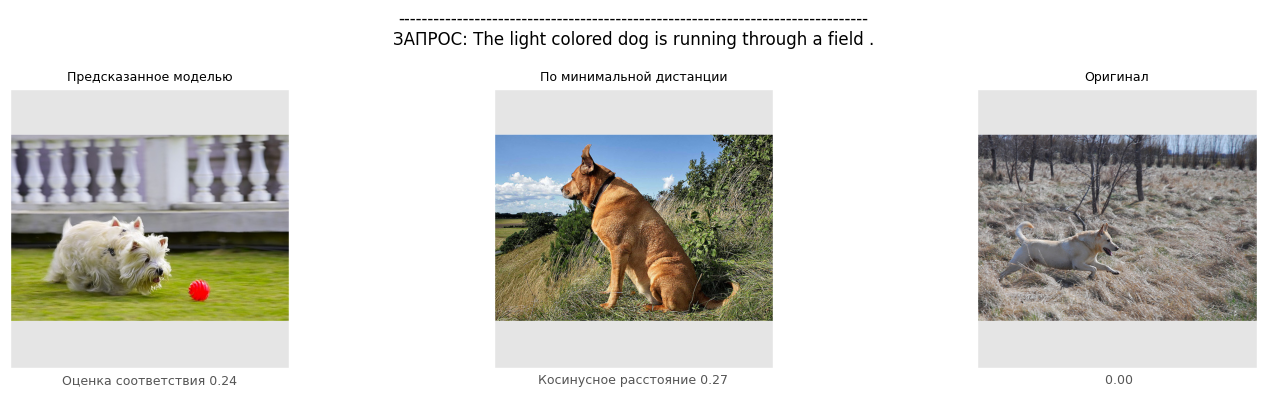

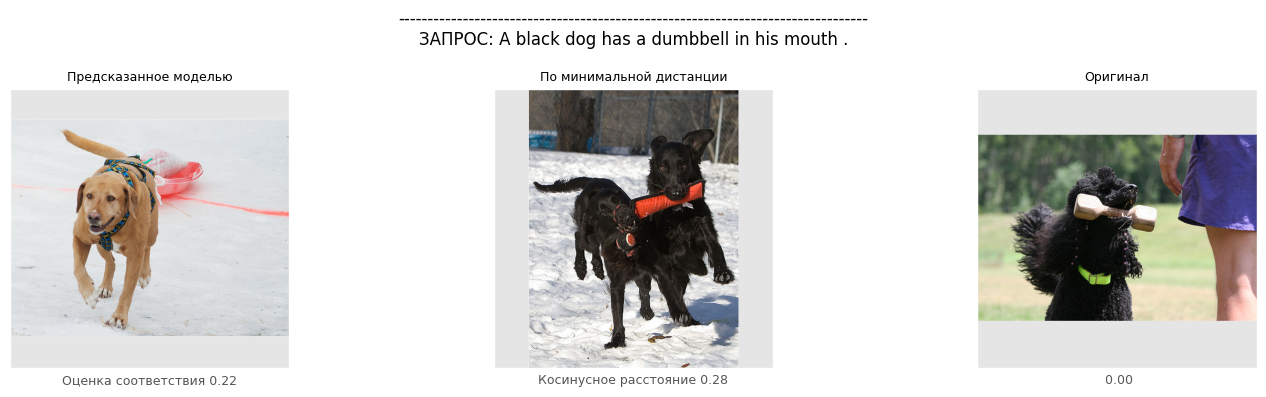

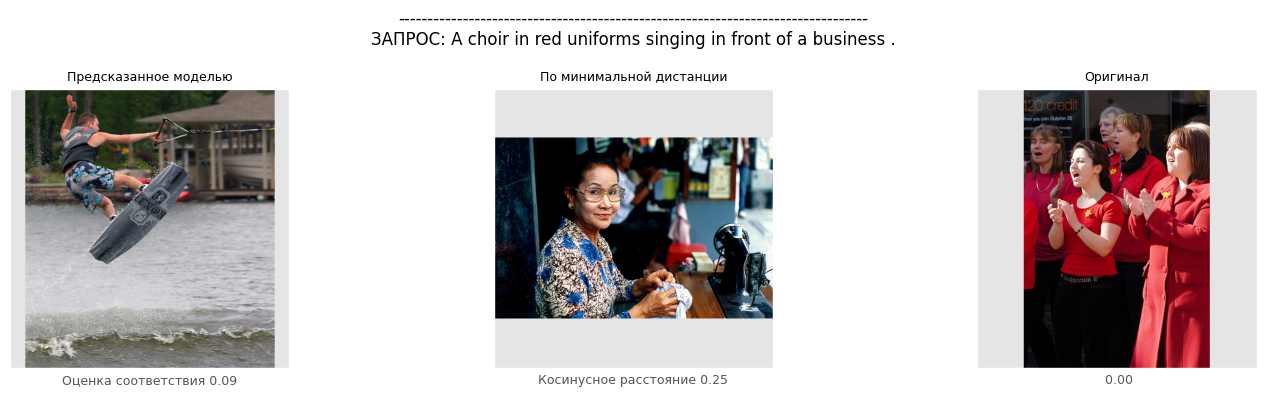

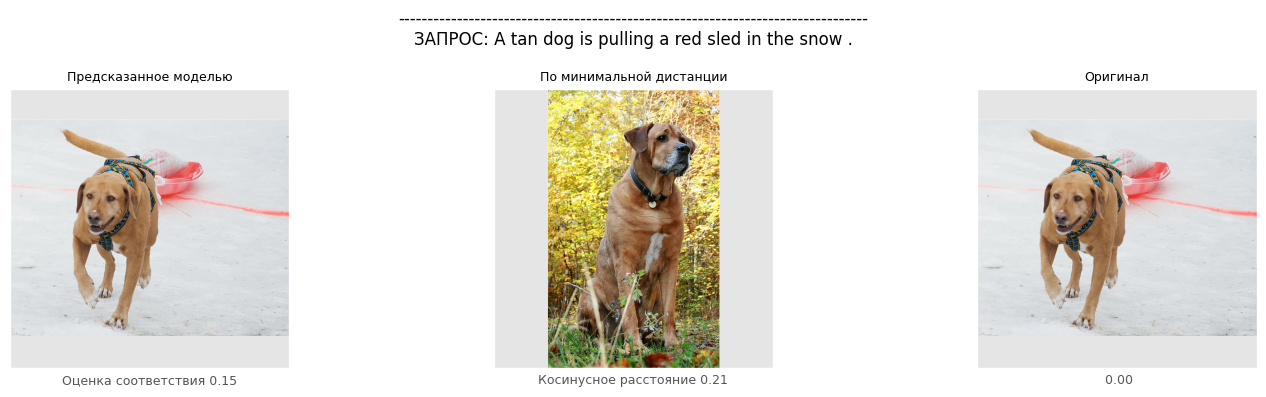

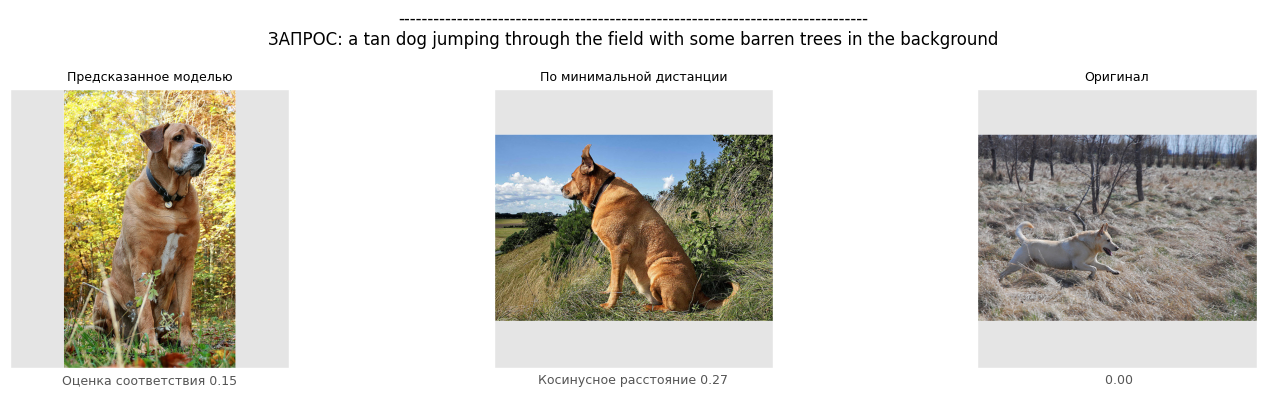

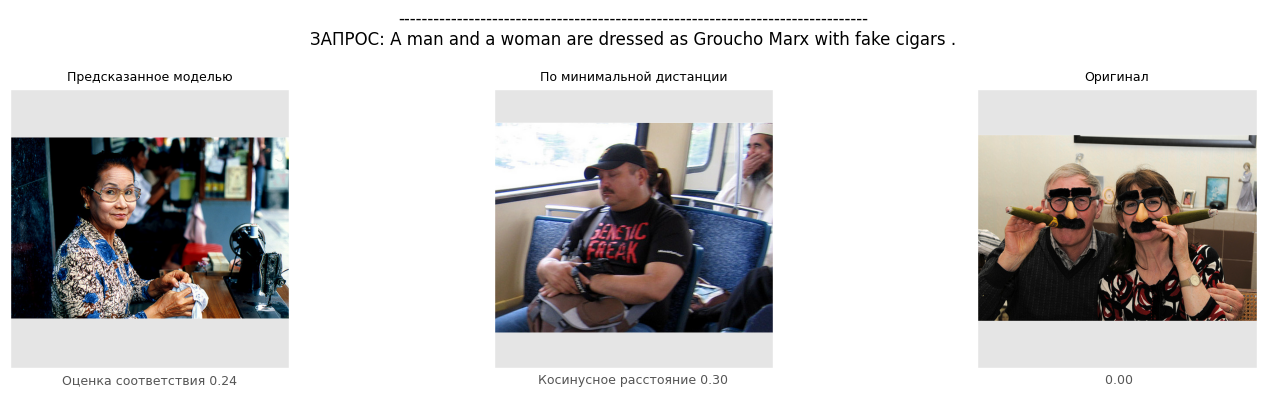

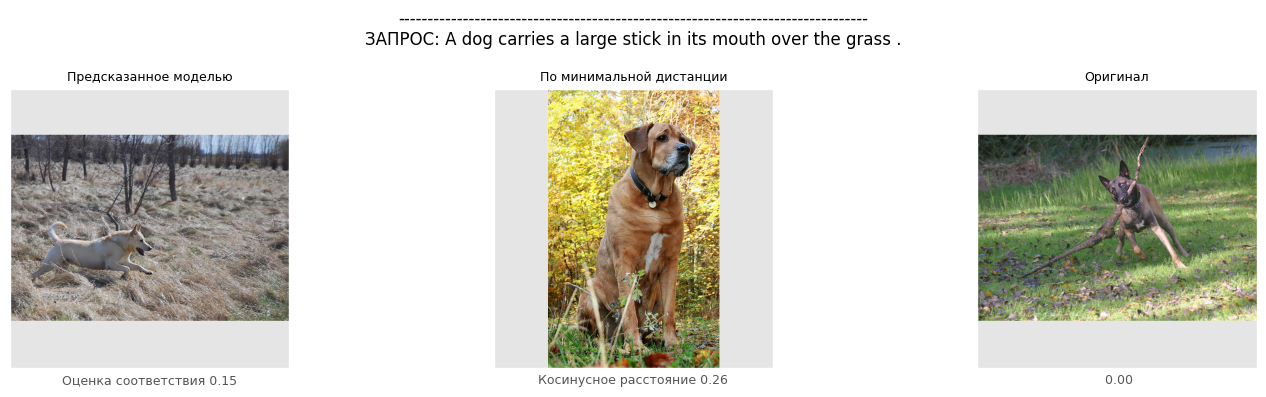

In [ ]:
open_image = lambda x: Image.open(os.path.join(TEST_IMG_FOLDER, x))

def result_plot(n, img, title, score, label_score):
    fig.add_subplot(1,3,n).set_title(title, fontsize=9)
    plt.imshow(make_square(img))
    plt.xlabel(f'{label_score} {score:.2f}', fontsize=9)
    plt.xticks([])
    plt.yticks([])

def prohibited_query():
    plt.text(0.5, 0.5, 'Детей не обсуждаем', color='red', fontsize='30', weight='bold', ha='center', va='center')
    plt.xticks([])
    plt.yticks([])
    plt.show()

for row in result.itertuples():
    fig = plt.figure(figsize=(15, 4))
    plt.suptitle(f'{"-"*80}\nЗАПРОС: {row.txt}')

    if any(w in row.txt.lower() for w in to_remove_kids):
        prohibited_query()
    else:
        img_pred = open_image(row.img_by_pred)
        img_dist = open_image(row.img_by_dist)
        img_src = open_image(row.src)

        result_plot(1, img_pred, 'Предсказанное моделью', row.scr, 'Оценка соответствия')
        result_plot(2, img_dist, 'По минимальной дистанции', row.cos, 'Косинусное расстояние')
        result_plot(3, img_src, 'Оригинал', 0, '')

        plt.tight_layout()

    plt.show()


Если изучить получившиеся изображения можно заметить что модель пытается уловить сходство и иногда ей это удается в общих чертах, иногда в цветовой гамме. Но в целом качество поиска очень невысокое, зачастую по косинусному расстоянию можно найти более подходящий вариант.

## Заключение

Для подготовки демо-версии поиска изображений по описанию
- были изучены оценки экспертов и краудсорса
- созданы векторы изображений и текстов
- проведено обучение ряда моделей

### Наилучшая модель
- полносвязная нейронная сеть из пяти слоев
- метрика RMSE 0.22

Проведено испытание на тестовом датасете
- удалены запросы и изображения, касающиеся детей
- для сравнения изучены изображения
    - предсказанные моделью
    - найденные по минимальному косинусному расстоянию
    - для сравнения представлены оригиналы, соответствующие запросам

### Выводы
- данных для качественного обучения модели недостаточно
- данных недостаточно вообще ни для чего – в тестовом датасете почти нет изображений с хорошим соответствием тестовым запросам, это можно увидеть если пойти в папку с картинками и глазами посмотреть на них
- из того что есть – модель угадывает общие очертания фигур, иногда пытается уловить персонажей или действие, примерно попадает в цветовую гамму
- возможно стоит рассмотреть системы типа faiss для поиска похожих изображений по эмбеддингам